In [101]:
# Recursively check for the most important features
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns

import warnings 

warnings.filterwarnings("ignore")

In [102]:
df = pd.read_csv("../raw/kc_house_data_train.csv", index_col=0)

In [103]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [104]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()  # by default this will use the mean

dummy.fit(X_train, y_train)

dummy.score(X_train, y_train) # the score of a regression model is the r-squared value

0.0

In [105]:
# Split the data
X = df.drop(columns="price")
y = df.price

In [106]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [107]:
# only look at usable columns
features = X_train.drop(columns=[
    "date",
    "id",
])
len(features) == len(y_train)

True

In [61]:
# Instantiate the linear regression model
lr = LinearRegression()


In [62]:
# Recursively check for the most important features

rfe = RFE(estimator=lr, n_features_to_select=7, step=1)
rfe = rfe.fit(features, y_train)
selected_rfe_features= pd.DataFrame({'Feature': list(features.columns),
                                    'Ranking': rfe.ranking_})
top_features = selected_rfe_features.sort_values(by='Ranking')
top_features.head()

,Feature,Ranking
8,grade,1
15,long,1
2,sqft_living,1
14,lat,1
5,waterfront,1


In [63]:
colinearity = X_train[top_features.iloc[:7,0]]

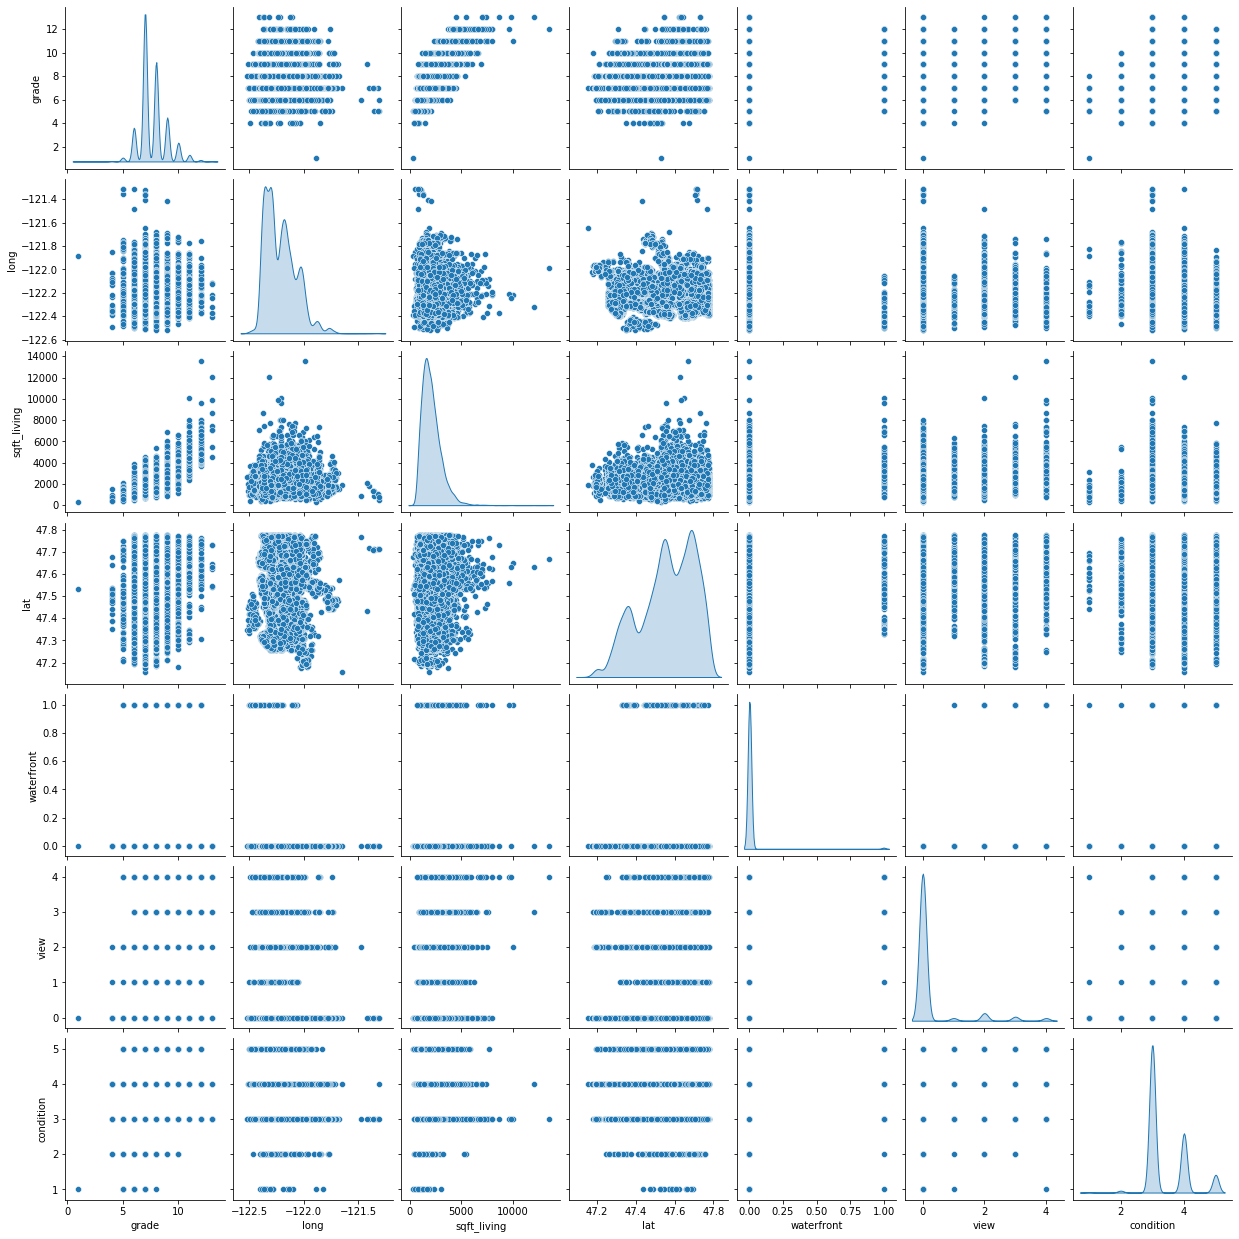

In [64]:
sns.pairplot(colinearity, diag_kind='kde');

In [65]:
# Let's look into the sqrfoot living of the data set and check for outliers
X_train.sqft_living.describe()

count    13832.000000
mean      2088.700333
std        927.352740
min        290.000000
25%       1430.000000
50%       1920.000000
75%       2555.500000
max      13540.000000
Name: sqft_living, dtype: float64

In [66]:
X_train[X_train.sqft_living > 5000].sqft_living.describe()

count      141.000000
mean      6043.595745
std       1284.080043
min       5010.000000
25%       5270.000000
50%       5584.000000
75%       6490.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [79]:
# Let's try and categorize the sqrfoot living into small, regular, large and mansion
def living_space(n):
    if n < 1500:
        return 'small'
    elif n < 2500:
        return 'medium'
    elif n < 5000:
        return 'large'
    else:
        return 'very_large'

In [80]:
X_train['size_cat']=X_train.sqft_living.apply(lambda x: living_space(x))
X_train.size_cat.value_counts()

medium        6166
small         3913
large         3610
very_large     143
Name: size_cat, dtype: int64

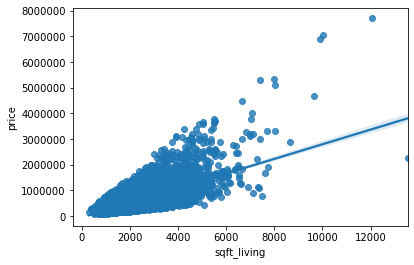

In [83]:
sns.regplot(X_train.sqft_living, y_train)

### Let's have a look into the time of the year that the house is sold

Let's get the dummy columns for the month of the year. We can reduce the months to seasons if we need to. 

In [141]:
# Let's look at date, Categorize them into months. 

X_train.date = pd.to_datetime(X_train.date)

In [142]:
X_train['month'] = X_train.date.dt.strftime("%m")

In [144]:
dummy_months = pd.get_dummies(X_train.month)

In [136]:
dummy = DummyRegressor()  # by default this will use the mean

dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.0

In [137]:
y_pred = dummy.predict(X_train)
dummy_rmse = mean_squared_error(y_train, y_pred)
dummy_rmse**0.5

375388.594116481

In [138]:
lr = LinearRegression()

In [139]:
X_date_test = X_train['month']

In [145]:
lr.fit(dummy_months, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [147]:
month_prediction = lr.predict(dummy_months)

In [149]:

month_rmse = mean_squared_error(y_train, month_prediction )
month_rmse**0.5

374932.5456784267

In [152]:
month_cat = pd.concat([dummy_months, X_train], axis= 1)

In [155]:
month_cat.drop(columns='date', inplace=True)
month_cat.head()

,1,2,3,4,5,6,7,8,9,10,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
2498,0,0,0,0,0,1,0,0,0,0,...,2370,0,2009,0,98019,47.7333,-121.975,2130,6850,06
10932,0,0,0,0,1,0,0,0,0,0,...,1040,1040,1955,0,98178,47.4866,-122.232,1780,14659,05
15638,0,0,0,0,0,1,0,0,0,0,...,700,0,1907,0,98106,47.5662,-122.364,1340,5000,06
15099,1,0,0,0,0,0,0,0,0,0,...,1460,1030,1978,0,98023,47.3115,-122.396,2000,8000,01
15560,0,0,0,0,0,0,0,0,0,0,...,1680,290,2007,0,98144,47.5816,-122.296,1940,6000,12


In [156]:
lr.fit(month_cat, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
month_cat_predict = lr.predict(month_cat)

In [160]:
month_cat_rmse = mean_squared_error(y_train, month_cat_predict)
month_cat_rmse**0.5

206007.713338503

### Improvement!

We have reduced the RMSE by over 100k over the dummy regression! We are looking crisp.